In [ ]:
%%shell
pip install pycocotools
pip3 install --upgrade albumentations
pip3 install opencv-python-headless==4.1.2.30
pip3 uninstall urllib3 --y
pip3 install urllib3
#pip install deeplake
pip install pytorch_lightning
pip install --upgrade wandb
pip install torchmetrics
pip install torchinfo
unzip model.zip
rm model.zip

mkdir coco
cd coco

#wget http://images.cocodataset.org/zips/train2017.zip
wget http://images.cocodataset.org/zips/val2017.zip
#wget http://images.cocodataset.org/zips/test2017.zip
#wget http://images.cocodataset.org/zips/unlabeled2017.zip

#unzip train2017.zip
unzip val2017.zip
#unzip test2017.zip
#unzip unlabeled2017.zip

#rm train2017.zip
rm val2017.zip
#rm test2017.zip
#rm unlabeled2017.zip 

wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
#wget http://images.cocodataset.org/annotations/image_info_test2017.zip
#wget http://images.cocodataset.org/annotations/image_info_unlabeled2017.zip

unzip annotations_trainval2017.zip
unzip stuff_annotations_trainval2017.zip
#unzip image_info_test2017.zip
#unzip image_info_unlabeled2017.zip

rm annotations_trainval2017.zip
rm stuff_annotations_trainval2017.zip
#rm image_info_test2017.zip
#rm image_info_unlabeled2017.zip

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import random_split
from coco import COCODataset
import torch

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = COCODataset(data_dir='coco/', split='val2017', train=True, mode='val')

tot = len(dataset)
trainset, valset = torch.utils.data.random_split(dataset, [len(dataset) - 500, 500])

train_dataloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=16, num_workers=2, collate_fn=collate_fn)
val_dataloader  = torch.utils.data.DataLoader(valset, shuffle=False, batch_size=2, num_workers=2, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


In [11]:
batch = next(iter(train_dataloader))

{'image_id': tensor([532575]), 'boxes': tensor([[  0.0000,  33.4948, 172.1851, 224.0000],
        [  0.0000,   0.0000, 223.6489, 221.2815]]), 'labels': tensor([18,  9])}


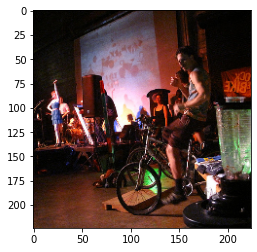

In [12]:
print(batch[1][1])
targets = [{k:v for k, v in t.items()} for t in batch[1]]
image = list(image for image in batch[0])
plt.imshow(image[0].permute(1,2,0))
plt.show()

### Model

In [ ]:
import models.vit_dino as vit_dino
import torch

model = vit_dino.__dict__['vit_tiny'](num_classes=91)
torch.save(model.state_dict(), 'vit_tiny.pth')

In [3]:
## Attaching ViT and MaskRCNN
import models.vit_dino as vit_dino
import torch
from torchvision.models.detection import FasterRCNN, MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
import torch
import torchvision
import torch.nn as nn
from torchinfo import summary


class ModifyViT(nn.Module):
    def __init__(self, num_classes=79, pretrained=False):
        super(ModifyViT, self).__init__()
        self.model = vit_dino.__dict__['vit_tiny'](num_classes=num_classes, use_clf_token=True,
                                                     use_positional_embeddings=True)
        self.patch_size = 16 // 2

        if pretrained:
            self.model.load_state_dict(torch.load('vit_tiny.pth'))

    def forward(self, x):
        out = self.model(x)
        x = out['z_patches']
        x = x.reshape(x.shape[0], -1, self.patch_size, self.patch_size)
        return x

In [ ]:
model = ModifyViT()
model(torch.rand(1,3,224,224)).shape

torch.Size([1, 588, 8, 8])

In [4]:
def create_model(num_classes = 91, pretrained = False, min_size = 200, max_size = 1300):

    backbone = ModifyViT(num_classes = num_classes, pretrained=False)
    backbone.out_channels = 588

    #backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
    #backbone.out_channels = 1280

    anchorgen = AnchorGenerator(sizes=((32, 64, 128, 256),),
                                            aspect_ratios=((0.5, 1.0, 2.0),))
    pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=4, sampling_ratio=2)

    model = FasterRCNN(backbone=backbone, min_size=min_size, max_size=max_size,
                                num_classes=num_classes,
                                rpn_anchor_generator=anchorgen, box_roi_pool=pooler,)

    #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=num_classes,pretrained=False)
    return model

model = create_model()

In [ ]:
model = create_model()
summary(model)

In [ ]:
# Eval
x = torch.rand(1, 3, 224, 224)
model.train(False)
x = model(x)
print('Eval Results:', x)

Eval Results: [{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}]


In [ ]:
# Train
x = next(iter(val_dataloader))
images  = list(image for image in x[0])
targets = [{k:v for k, v in t.items()} for t in x[1]]

model.train(True)
x = model(images, targets)
print('Train Results:',x)

Train Results: {'loss_classifier': tensor(4.4934, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0715, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.7008, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0852, grad_fn=<DivBackward0>)}


### Training

In [6]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.utils.data import random_split, DataLoader
from torchmetrics import Accuracy
from coco import COCODataset
import torch
import wandb

def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
class ObjectDetector(pl.LightningModule):
    def __init__(self, num_classes, lr=0.0001, weight_decay=0.0005):
        super().__init__()
        self.model = create_model(num_classes=num_classes, pretrained=True)
        self.lr = lr
        self.weight_decay = weight_decay
        self.map_box = MeanAveragePrecision(box_format="xyxy", iou_type="bbox")
        self.batch_size_train = 32
        self.batch_size_val = 8
        self.data_dir = 'coco/'
        self.save_hyperparameters()

    def forward(self, x):
        return self.model.forward(x)

    def training_step(self, batch, batch_idx):
        model.train(True)

        images  = list(image for image in batch[0])
        targets = [{k:v for k, v in t.items()} for t in batch[1]]

        loss_dict = self.model(images, targets)

        loss_cls = loss_dict['loss_classifier']
        loss_box_reg = loss_dict['loss_box_reg']
        loss_obj = loss_dict['loss_objectness']
        losses = sum(loss for loss in loss_dict.values())

        self.log('train_loss', losses, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size = self.batch_size_train)
        self.log('train_loss_cls', loss_cls, on_step=True, on_epoch=True, batch_size = self.batch_size_train)
        self.log('train_loss_box_reg', loss_box_reg, on_step=True, on_epoch=True, batch_size = self.batch_size_train)
        self.log('train_loss_obj', loss_obj, on_step=True, on_epoch=True, batch_size = self.batch_size_train) 
        return losses

    def validation_step(self, batch, batch_idx):
        model.train(False)
        images  = list(image for image in batch[0])
        targets = [{k:v for k, v in t.items()} for t in batch[1]]
         
        preds = self.model(images)

        self.map_box.update(preds=preds, target=targets)

    def validation_epoch_end(self, validation_step_outputs):

        mAPs_box = {"val_box_" + k: v for k, v in self.map_box.compute().items()}     

        self.print(mAPs_box)
        self.log_dict(mAPs_box, sync_dist=True)
        self.map_box.reset()

    def configure_optimizers(self):
        params = [p for p in self.model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9, weight_decay=self.weight_decay)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=5e-4)

        return {"optimizer":optimizer, "lr_scheduler": sch}

    ####################
    # DATA RELATED HOOKS
    ####################   

    def prepare_data(self):
        dataset = COCODataset(data_dir=self.data_dir, split='val2017', train=True, mode='val')
        self.trainset, self.valset = random_split(dataset, [len(dataset) - 500, 500])

    def train_dataloader(self):
        return DataLoader(self.trainset, shuffle=True, batch_size=self.batch_size_train, num_workers=2,
                          collate_fn=collate_fn)

    def val_dataloader(self):
        return DataLoader(self.valset, shuffle=False, batch_size=self.batch_size_val, num_workers=2,
                          collate_fn=collate_fn)

In [8]:
NUM_CLASSES=91
n_epochs = 20
version = 'Version 0.0'


lr_monitor = LearningRateMonitor(logging_interval='step')
detector = ObjectDetector(num_classes=NUM_CLASSES, lr=0.01, weight_decay=0.0001)

wandb_logger = WandbLogger(project='Faster-RCNN', name=version,
                           save_dir='Prova_FasterRCNN',log_model=True)

trainer = pl.Trainer(accelerator="auto", max_epochs=n_epochs, 
                     callbacks=[lr_monitor] , logger=wandb_logger)

trainer.fit(detector)
wandb.finish()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:322: UserWarning: Providing log_model=True requires wandb version >= 0.10.22 for logging associated model metadata.
Hint: Upgrade with `pip install --upgrade wandb`.
  rank_zero_warn(
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: WARNING Path Prova_FasterRCNN/wandb/ wasn't writable, using system temp directory.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
Checking the dataset...
checked id file: coco/checked_val2017.txt
4952 samples are OK; 0.7 seconds


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                 | Params
-------------------------------------------------
0 | model   | FasterRCNN           | 19.8 M
1 | map_box | MeanAveragePrecision | 0     
-------------------------------------------------
19.8 M    Trainable params
0         Non-trainable params
19.8 M    Total params
79.291    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

{'val_box_map': tensor(0.), 'val_box_map_50': tensor(0.), 'val_box_map_75': tensor(0.), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(0.), 'val_box_map_large': tensor(0.), 'val_box_mar_1': tensor(0.), 'val_box_mar_10': tensor(0.), 'val_box_mar_100': tensor(0.), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(0.), 'val_box_mar_large': tensor(0.), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(2.8899e-05), 'val_box_map_50': tensor(9.0757e-05), 'val_box_map_75': tensor(1.6282e-05), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(0.), 'val_box_map_large': tensor(0.0002), 'val_box_mar_1': tensor(0.0002), 'val_box_mar_10': tensor(0.0002), 'val_box_mar_100': tensor(0.0002), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(0.), 'val_box_mar_large': tensor(0.0016), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(3.6209e-05), 'val_box_map_50': tensor(0.0001), 'val_box_map_75': tensor(1.3850e-05), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(0.), 'val_box_map_large': tensor(0.0002), 'val_box_mar_1': tensor(0.0002), 'val_box_mar_10': tensor(0.0004), 'val_box_mar_100': tensor(0.0004), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(0.), 'val_box_mar_large': tensor(0.0030), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(0.0001), 'val_box_map_50': tensor(0.0003), 'val_box_map_75': tensor(0.0001), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(1.9828e-05), 'val_box_map_large': tensor(0.0004), 'val_box_mar_1': tensor(0.0002), 'val_box_mar_10': tensor(0.0006), 'val_box_mar_100': tensor(0.0006), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(3.8495e-05), 'val_box_mar_large': tensor(0.0041), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(5.5958e-05), 'val_box_map_50': tensor(0.0002), 'val_box_map_75': tensor(1.8778e-05), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(5.0221e-05), 'val_box_map_large': tensor(0.0003), 'val_box_mar_1': tensor(0.0002), 'val_box_mar_10': tensor(0.0006), 'val_box_mar_100': tensor(0.0006), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(8.3333e-05), 'val_box_mar_large': tensor(0.0047), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(5.2648e-05), 'val_box_map_50': tensor(0.0002), 'val_box_map_75': tensor(1.2546e-05), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(6.3918e-05), 'val_box_map_large': tensor(0.0003), 'val_box_mar_1': tensor(0.0002), 'val_box_mar_10': tensor(0.0006), 'val_box_mar_100': tensor(0.0006), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(0.0001), 'val_box_mar_large': tensor(0.0045), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(5.6620e-05), 'val_box_map_50': tensor(0.0002), 'val_box_map_75': tensor(1.4923e-05), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(8.7446e-06), 'val_box_map_large': tensor(0.0003), 'val_box_mar_1': tensor(0.0003), 'val_box_mar_10': tensor(0.0006), 'val_box_mar_100': tensor(0.0006), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(2.8444e-05), 'val_box_mar_large': tensor(0.0047), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(8.4129e-05), 'val_box_map_50': tensor(0.0003), 'val_box_map_75': tensor(9.4068e-06), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(1.8850e-05), 'val_box_map_large': tensor(0.0004), 'val_box_mar_1': tensor(0.0002), 'val_box_mar_10': tensor(0.0006), 'val_box_mar_100': tensor(0.0006), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(4.5257e-05), 'val_box_mar_large': tensor(0.0042), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(6.2624e-05), 'val_box_map_50': tensor(0.0002), 'val_box_map_75': tensor(2.5769e-05), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(4.9285e-05), 'val_box_map_large': tensor(0.0004), 'val_box_mar_1': tensor(0.0003), 'val_box_mar_10': tensor(0.0006), 'val_box_mar_100': tensor(0.0006), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(3.5461e-05), 'val_box_mar_large': tensor(0.0046), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(8.6426e-05), 'val_box_map_50': tensor(0.0002), 'val_box_map_75': tensor(6.9201e-05), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(3.3847e-05), 'val_box_map_large': tensor(0.0004), 'val_box_mar_1': tensor(0.0002), 'val_box_mar_10': tensor(0.0006), 'val_box_mar_100': tensor(0.0006), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(7.0922e-05), 'val_box_mar_large': tensor(0.0046), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(5.5041e-05), 'val_box_map_50': tensor(0.0002), 'val_box_map_75': tensor(1.6865e-05), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(6.9113e-05), 'val_box_map_large': tensor(0.0004), 'val_box_mar_1': tensor(0.0002), 'val_box_mar_10': tensor(0.0007), 'val_box_mar_100': tensor(0.0007), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(6.8201e-05), 'val_box_mar_large': tensor(0.0052), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(4.8443e-05), 'val_box_map_50': tensor(0.0002), 'val_box_map_75': tensor(1.1430e-05), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(3.9725e-05), 'val_box_map_large': tensor(0.0003), 'val_box_mar_1': tensor(0.0002), 'val_box_mar_10': tensor(0.0006), 'val_box_mar_100': tensor(0.0006), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(8.8652e-05), 'val_box_mar_large': tensor(0.0043), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(5.5894e-05), 'val_box_map_50': tensor(0.0002), 'val_box_map_75': tensor(1.3060e-05), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(4.8127e-05), 'val_box_map_large': tensor(0.0004), 'val_box_mar_1': tensor(0.0003), 'val_box_mar_10': tensor(0.0006), 'val_box_mar_100': tensor(0.0006), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(7.0175e-05), 'val_box_mar_large': tensor(0.0047), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(6.8275e-05), 'val_box_map_50': tensor(0.0002), 'val_box_map_75': tensor(1.8434e-05), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(4.6605e-05), 'val_box_map_large': tensor(0.0004), 'val_box_mar_1': tensor(0.0003), 'val_box_mar_10': tensor(0.0006), 'val_box_mar_100': tensor(0.0006), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(4.1667e-05), 'val_box_mar_large': tensor(0.0046), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(0.0001), 'val_box_map_50': tensor(0.0003), 'val_box_map_75': tensor(0.0001), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(8.0455e-05), 'val_box_map_large': tensor(0.0004), 'val_box_mar_1': tensor(0.0002), 'val_box_mar_10': tensor(0.0006), 'val_box_mar_100': tensor(0.0006), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(5.9182e-05), 'val_box_mar_large': tensor(0.0039), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(0.0001), 'val_box_map_50': tensor(0.0003), 'val_box_map_75': tensor(0.0001), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(6.1858e-05), 'val_box_map_large': tensor(0.0004), 'val_box_mar_1': tensor(0.0002), 'val_box_mar_10': tensor(0.0006), 'val_box_mar_100': tensor(0.0006), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(6.2338e-05), 'val_box_mar_large': tensor(0.0044), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(6.1270e-05), 'val_box_map_50': tensor(0.0002), 'val_box_map_75': tensor(3.0177e-05), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(4.1191e-05), 'val_box_map_large': tensor(0.0003), 'val_box_mar_1': tensor(0.0002), 'val_box_mar_10': tensor(0.0006), 'val_box_mar_100': tensor(0.0006), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(9.1954e-05), 'val_box_mar_large': tensor(0.0042), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(0.0003), 'val_box_map_50': tensor(0.0006), 'val_box_map_75': tensor(0.0002), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(3.4308e-05), 'val_box_map_large': tensor(0.0008), 'val_box_mar_1': tensor(0.0007), 'val_box_mar_10': tensor(0.0010), 'val_box_mar_100': tensor(0.0010), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(4.9514e-05), 'val_box_mar_large': tensor(0.0052), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(0.0005), 'val_box_map_50': tensor(0.0011), 'val_box_map_75': tensor(0.0005), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(3.9934e-05), 'val_box_map_large': tensor(0.0014), 'val_box_mar_1': tensor(0.0021), 'val_box_mar_10': tensor(0.0024), 'val_box_mar_100': tensor(0.0024), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(3.7898e-05), 'val_box_mar_large': tensor(0.0085), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(0.0006), 'val_box_map_50': tensor(0.0011), 'val_box_map_75': tensor(0.0005), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(4.4824e-05), 'val_box_map_large': tensor(0.0015), 'val_box_mar_1': tensor(0.0027), 'val_box_mar_10': tensor(0.0031), 'val_box_mar_100': tensor(0.0031), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(4.5494e-05), 'val_box_mar_large': tensor(0.0109), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


Validation: 0it [00:00, ?it/s]

{'val_box_map': tensor(0.0004), 'val_box_map_50': tensor(0.0009), 'val_box_map_75': tensor(0.0002), 'val_box_map_small': tensor(0.), 'val_box_map_medium': tensor(1.1706e-05), 'val_box_map_large': tensor(0.0011), 'val_box_mar_1': tensor(0.0021), 'val_box_mar_10': tensor(0.0025), 'val_box_mar_100': tensor(0.0025), 'val_box_mar_small': tensor(0.), 'val_box_mar_medium': tensor(0.0002), 'val_box_mar_large': tensor(0.0094), 'val_box_map_per_class': tensor(-1.), 'val_box_mar_100_per_class': tensor(-1.)}


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
lr-SGD,████▇▇▇▇▆▆▅▅▃▃▂▂▂▂▁▁▁▁▁▁▂▂▂▂▃▃▅▅▆▆▇▇▇▇██
train_loss_box_reg_epoch,█▄▅▄▄▃▄▄▄▄▄▄▃▃▂▃▃▂▁▂
train_loss_box_reg_step,▄▅▄▂▁▂▃▂▄▄▄▁▄▄▃▅▄▁▂▁▄▄▄▂▂▃▂▁▃▃▂▄▂▂▃▄▅▃▂█
train_loss_cls_epoch,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_cls_step,▅▅▄▃▁▂▃▁▃▄▃▂▃▃▂▄▃▂▂▂▃▂▃▃▂▃▂▁▂▂▂▄▃▁▂▃▃▂▃█
train_loss_epoch,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_obj_epoch,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_obj_step,█▅▅▄▁▃▄▂▃▅▄▃▄▄▂▃▄▃▄▃▃▃▄▄▃▃▄▂▃▃▃▃▃▂▂▃▄▂▄█
train_loss_step,▅▅▄▃▁▂▃▂▃▄▃▂▃▃▂▄▃▂▃▂▃▃▄▃▂▃▃▁▃▂▂▃▃▂▂▃▄▂▃█
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███


In [ ]:
model

In [ ]:
from pytorch_lightning.callbacks import Callback
 
class LogPredictionsCallback(Callback):
    
    def on_validation_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        """Called when the validation batch ends."""
 
        # `outputs` comes from `LightningModule.validation_step`
        # which corresponds to our model predictions in this case
        
        # Let's log 20 sample image predictions from first batch
        if batch_idx == 0:
            n = 20
            x, y = batch
            images = [img for img in x[:n]]
            captions = [f'Ground Truth: {y_i} - Prediction: {y_pred}' for y_i, y_pred in zip(y[:n], outputs[:n])]
            
            # Option 1: log images with `WandbLogger.log_image`
            wandb_logger.log_image(key='sample_images', images=images, caption=captions)

            # Option 2: log predictions as a Table
            columns = ['image', 'ground truth', 'prediction']
            data = [[wandb.Image(x_i), y_i, y_pred] for x_i, y_i, y_pred in list(zip(x[:n], y[:n], outputs[:n]))]
            wandb_logger.log_table(key='sample_table', columns=columns, data=data)

log_predictions_callback = LogPredictionsCallback()

In [ ]:
class MaskRCNNDetector(pl.LightningModule):
    def __init__(self, num_classes, lr=0.0001, weight_decay=0.0005):
        super().__init__()
        self.model = create_model(num_classes=num_classes, pretrained=True)
        self.lr = lr
        self.weight_decay = weight_decay
        self.map_box = MeanAveragePrecision(box_format="xyxy", iou_type="bbox")
        self.map_mask = MeanAveragePrecision(iou_type="segm")
        self.batch_size = 64

    def forward(self, x):
        return self.model.forward(x)

    def training_step(self, batch, batch_idx):
        model.train(True)

        images  = list(image for image in batch[0])
        targets = [{k:v for k, v in t.items()} for t in batch[1]]

        loss_dict = self.model(images, targets)

        loss_cls = loss_dict['loss_classifier']
        loss_box_reg = loss_dict['loss_box_reg']
        loss_mask = loss_dict['loss_mask']
        losses = sum(loss for loss in loss_dict.values())

        self.log('train_loss', losses, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size = self.batch_size)
        self.log('train_loss_cls', loss_cls, on_step=True, on_epoch=True, batch_size = self.batch_size)
        self.log('train_loss_box_reg', loss_box_reg, on_step=True, on_epoch=True, batch_size = self.batch_size)
        self.log('train_loss_mask', loss_mask, on_step=True, on_epoch=True, batch_size = self.batch_size)
        return losses

    def validation_step(self, batch, batch_idx):
        model.train(False)
        images  = list(image for image in batch[0])
        targets = [{k:v for k, v in t.items()} for t in batch[1]]
         
        preds = self.model(images)

        # for i in range(len(preds)):
        #     preds[i]['masks'] = preds[i]['masks'].squeeze(1)

        self.map_box.update(preds=preds, target=targets)
        #self.map_mask.update(preds=preds, target=targets)

    def validation_epoch_end(self, validation_step_outputs):

        mAPs_box = {"val_box_" + k: v for k, v in self.map_box.compute().items()}     
        #mAPs_mask = {"val_mask_" + k: v for k, v in self.map_mask.compute().items()}

        self.print(mAPs_box)
        #self.print(mAPs_mask)

        self.log_dict(mAPs_box, sync_dist=True)
        #self.log_dict(mAPs_mask, sync_dist=True)

        self.map_box.reset()
        #self.map_mask.reset()

    def configure_optimizers(self):
        params = [p for p in self.model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9, weight_decay=self.weight_decay)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8, eta_min=1e-4)
        # sch = torch.optim.lr_scheduler.StepLR(
        # optimizer, step_size  = 2 , gamma = 0.5)

        return {"optimizer":optimizer, "lr_scheduler": sch}